In [10]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as sp
from scipy.sparse import csr_matrix

In [3]:
hf = h5py.File('clean_run_0102.h5', 'r')

In [7]:
events = hf['clean']

In [5]:
DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

x_disc = 20
y_disc = 20
z_disc = 20

x_inc = (2*DETECTOR_RADIUS)/x_disc
y_inc = (2*DETECTOR_RADIUS)/y_disc
z_inc = DETECTOR_LENGTH/z_disc

In [14]:
discElements = x_disc*y_disc*z_disc

discretized_xyz = np.zeros([events['1'].shape[0],events['1'].shape[1]])
buckets = []
charges = []
num_pts = 0
    
for point in events['1']:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    
    #sparse matrix implementation
    buckets.append(bucket_num)
    charges.append(point[3]/10)
    
    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0                          
    
    discretized_xyz[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4], point[5], point[6]]
    
    num_pts += 1
    
#create csr matrix where data is chrage and row np.zeros(len(col)) of size (1, discElements)
cols = buckets
rows = np.zeros(len(cols))
data = charges

#automatically sums data entries for data occuring at the same point
#no need for sum_duplicates()
discretized_data_sparse_CHARGE  = sp.sparse.csr_matrix((data, (rows, cols)), shape=(1, discElements))

print("buckets filled: " + str(len(np.unique(buckets))))
print("charge acumulated: " + str(sum(data)))

buckets filled: 61
charge acumulated: 7824.351915764349


In [15]:
normalized = np.linalg.norm(charges)
print(normalized)

716.4622935963697


In [17]:
#scatter plot coloring by charge
import seaborn as sns
from matplotlib.colors import LogNorm

In [18]:
ch_colors = sns.cubehelix_palette(n_colors=6, start=0, rot=-0.4,
                                  gamma=1, hue=1, light=0.75, dark=0.1)
ch_cm = sns.blend_palette(ch_colors, as_cmap=True)

Text(0.5, 0.92, 'downsampled with charge')

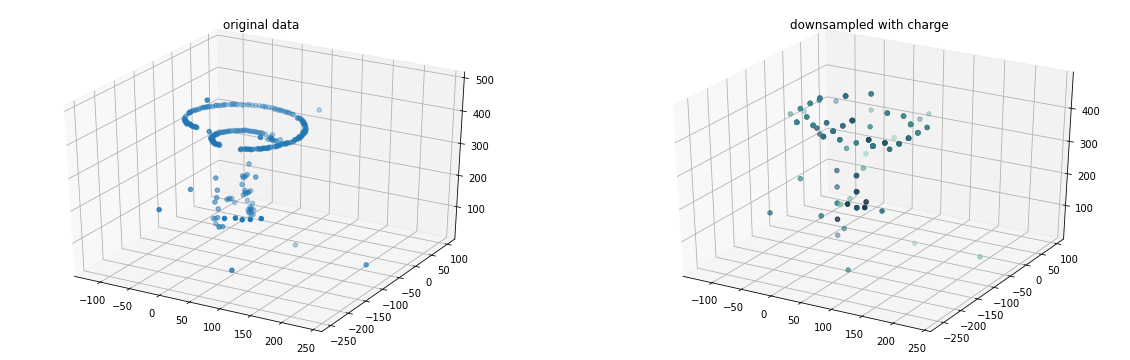

In [22]:
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(events['1'][:,0], events['1'][:,1], events['1'][:,2])
#ax.axis('equal')
ax.set_title("original data")

#######################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(discretized_xyz[:,0], discretized_xyz[:,1], discretized_xyz[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyz[:,3])
#ax.axis('equal')
ax.set_title('downsampled with charge')

